### Bio Clustering (Word2Vec and Kmeans Clustering)

In [6]:
import pandas as pd
import numpy as np
from time import time
import re
import os
import nltk
import gensim.models.word2vec as w2v

nltk.download("punkt")
nltk.download("stopwords")

from nltk.corpus import stopwords

from nltk import word_tokenize
from nltk.stem import PorterStemmer

import multiprocessing

import seaborn as sns
import gensim.models.word2vec as w2v
import matplotlib.pyplot as plt
import sklearn.manifold

from  sklearn.cluster import KMeans

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#### Reading file and creating dataframe

In [7]:
with open("_data/unlabled/bio_1501598612.022413.txt") as f:
    all_data = f.read().split('\n')

In [8]:
def clean_sentence(raw):
    noise_words = []
    stop_words = list(set(stopwords.words('english')))
    URL_REGEX = r"""(?i)\b((?:[a-z][\w-]+:(?:/{1,3}|[a-z0-9%])|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?<>""'']))"""
    raw = re.sub(URL_REGEX, '', raw, flags=re.MULTILINE)
    for n in noise_words:
        clean = raw.replace(n, " ")
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    stop_words = list(set(stopwords.words('english')))
    words = [w for w in words if w not in stop_words]
    return " ".join(words)

In [9]:
df = pd.DataFrame(all_data, columns=['bio'])
df.replace('', np.nan, inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.tail()

df = pd.DataFrame(df['bio'].apply(clean_sentence))
df.drop_duplicates(inplace=True)
df.count()

bio    13364
dtype: int64

#### Data Details

In [10]:
df.describe()

,bio
count,13364
unique,13364
top,Why thus reason thusness Vox Entertainment Vox...
freq,1


In [11]:
df['word_freq'] = df['bio'].apply(lambda x: len(x.split()))

#### Average sentence length

In [12]:
df['word_freq'].mean()

10.4408111343909

### Word2Vec Feature Extraction

In [13]:
def sentence_to_wordlist(text, stem=True):
    """ Tokenize text and stem words removing punctuation """
    tokens = word_tokenize(text.lower())
    return tokens

In [14]:
sentences = []
for raw_sentence in df['bio']:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [15]:
sentences[909]

['an',
 'online',
 'master',
 'information',
 'data',
 'science',
 'mids',
 'degree',
 'uc',
 'berkeley',
 'school',
 'information',
 'learn']

In [16]:
token_count = sum([len(sentence) for sentence in sentences])
print("The corpus contains {0:,} tokens".format(token_count))

The corpus contains 139,560 tokens


**Word2Vec model**



In [20]:
# Dimensionality of the resulting word vectors.
# more dimensions mean more training them, but more generalized
num_features = 300
# Minimum word count threshold.
min_word_count = 3
# Number of threads to run in parallel.
num_workers = multiprocessing.cpu_count()
# Context window length.
context_size = 7
# Downsample setting for frequent words.
#rate 0 and 1e-5 
#how often to use
downsampling = 1e-3
# Seed for the RNG, to make the results reproducible.
seed = 1

In [21]:
t0 = time()
bio_vec = w2v.Word2Vec(
    sentences,
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling,
    iter = 10
)

print("Train Time:", time()-t0)

Train Time: 14.896204233169556


In [22]:
if not os.path.exists("_data/trained"):
    os.makedirs("_data/trained")

bio_vec.save(os.path.join("_data/trained", "bioVectors.w2v"))

In [23]:
bio_vec.most_similar_cosmul("machine")

[('ai', 0.972197413444519),
 ('learning', 0.9702125787734985),
 ('deep', 0.9699937105178833),
 ('ml', 0.9607760906219482),
 ('machinelearning', 0.9593533873558044),
 ('deeplearning', 0.9565567374229431),
 ('brain', 0.9537150263786316),
 ('language', 0.9479606747627258),
 ('computational', 0.9464460015296936),
 ('scientist', 0.9441832304000854)]

In [24]:
print("Vocab Size:", len(bio_vec.wv.vocab.keys()))

Vocab Size: 6339


### Visualization and word-D-reduction

In [25]:
t1 = time()
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
all_word_vectors_matrix = bio_vec.wv.syn0
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)
print("Dimension reduction Time:", time()-t1)

MemoryError: 

In [26]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[bio_vec.wv.vocab[word].index])
            for word in bio_vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

NameError: name 'all_word_vectors_matrix_2d' is not defined

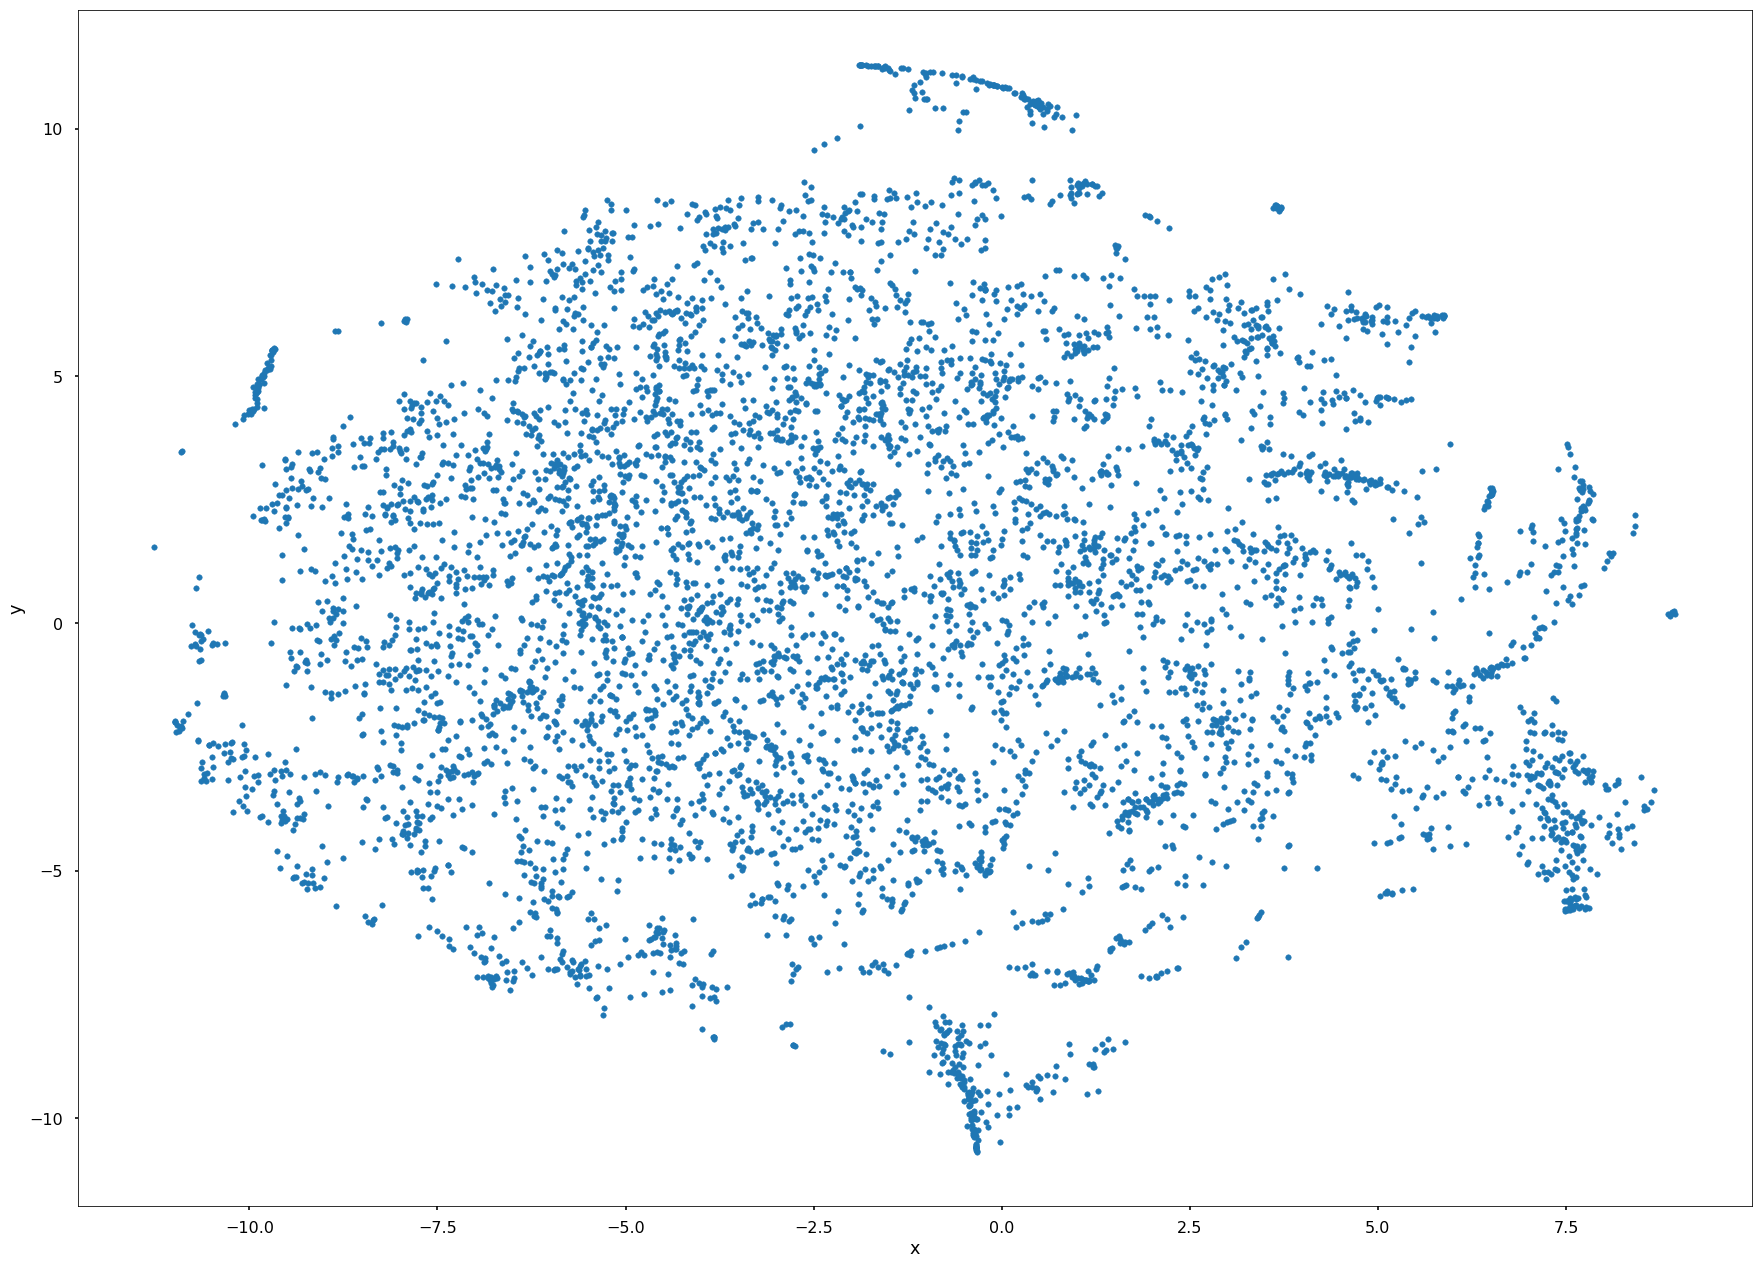

In [29]:
sns.set_context("poster")
points.plot.scatter("x", "y", s=30, figsize=(30, 22))
plt.show()

In [30]:
def plot_region(x_bounds, y_bounds):
    try:
        slice = points[
            (x_bounds[0] <= points.x) &
            (points.x <= x_bounds[1]) & 
            (y_bounds[0] <= points.y) &
            (points.y <= y_bounds[1])
        ]

        ax = slice.plot.scatter("x", "y", s=90, figsize=(10, 8))
        for i, point in slice.iterrows():
            ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)
    except:
        print("No word in this region")

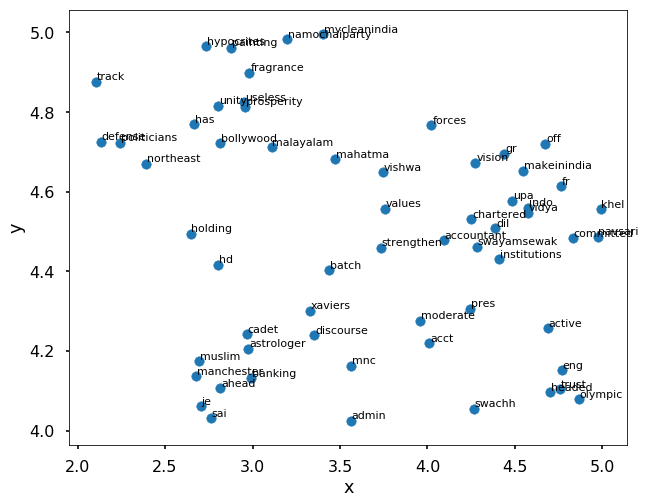

In [37]:
plot_region(x_bounds=(2, 5), y_bounds=(4, 5))

plt.show()

### Sentence Embedding and Clustering

In [27]:
def preprocess_text(raw):
    noise_words = []
    stop_words = list(set(stopwords.words('english')))
    URL_REGEX = r"""(?i)\b((?:[a-z][\w-]+:(?:/{1,3}|[a-z0-9%])|www\d{0,3}[.]|
                [a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+
                (?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?<>""'']))"""
    raw = re.sub(URL_REGEX, '', raw, flags=re.MULTILINE)
    for n in noise_words:
        clean = raw.replace(n, " ")
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    stop_words = list(set(stopwords.words('english')))
    words = [w for w in words if w not in stop_words]
    tokens = word_tokenize(raw.lower())
    return tokens

In [28]:
def embed_sentences(s):
    sample_text_tokens = preprocess_text(s)
    word_vectors = np.array([]).reshape(0, 300)
    for t in sample_text_tokens:
        if t in bio_vec.wv.vocab.keys():
            word_vectors = np.vstack([word_vectors, bio_vec[t]])
    if len(word_vectors):
        return np.array((np.max(word_vectors), np.min(word_vectors)))
    else:
        return [0, 0]

In [29]:
sentence_vectors = np.array([]).reshape(0, 2)

for index, row in df.iterrows():
    sentence_vectors = np.vstack([sentence_vectors, embed_sentences(row['bio'])])

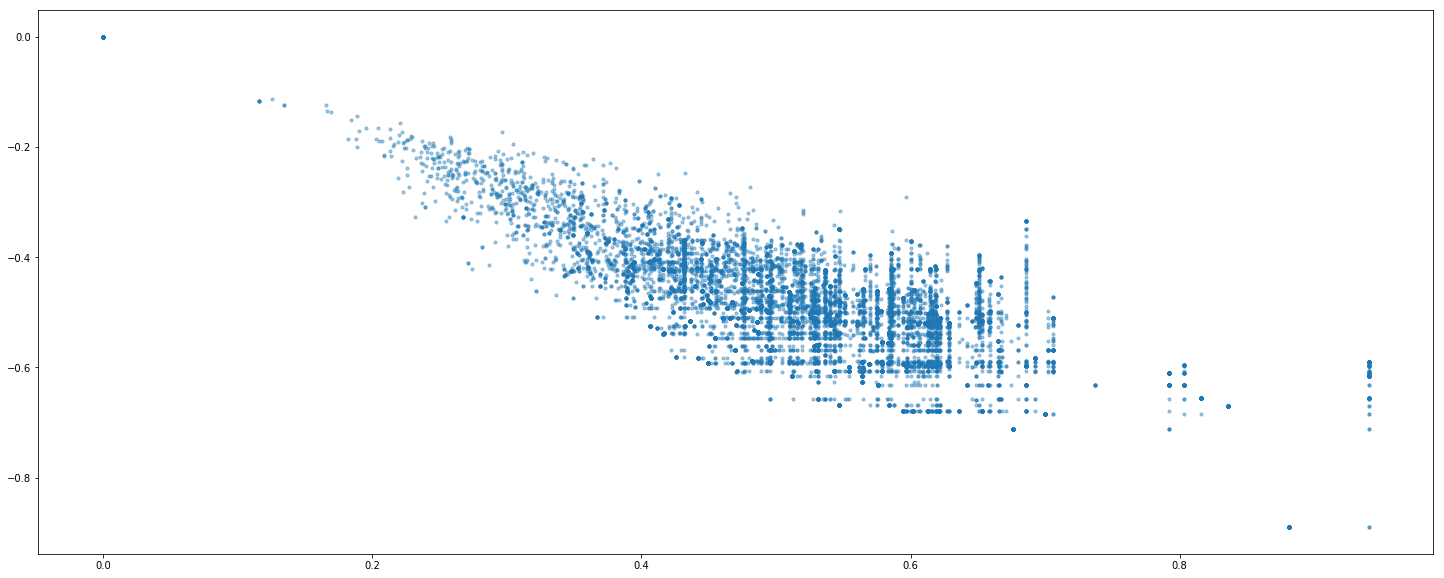

In [30]:
plt.figure(figsize=(25, 10))
plt.scatter([i[0] for i in sentence_vectors], [i[1] for i in sentence_vectors], s=10, alpha=0.4)
plt.show()

In [31]:
def kmeans(data, clus):
    km = KMeans(n_clusters=clus, init='k-means++', max_iter=1000, n_init=1,
                    verbose=False)

    print("Clustering sparse data with %s" % km)
    t0 = time()
    km.fit(data)
    print("done in %0.3fs" % (time() - t0))

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1


    plt.figure(figsize=(25, 10))
    plt.scatter(data[:, 0], data[:, 1], s=10, alpha=0.4)

    # Plot the centroids as a white X
    centroids = km.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=90, linewidths=1,
                color='r')
    plt.title('K-means clustering')
    plt.show()
    return km

Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=5, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=False)
done in 0.066s


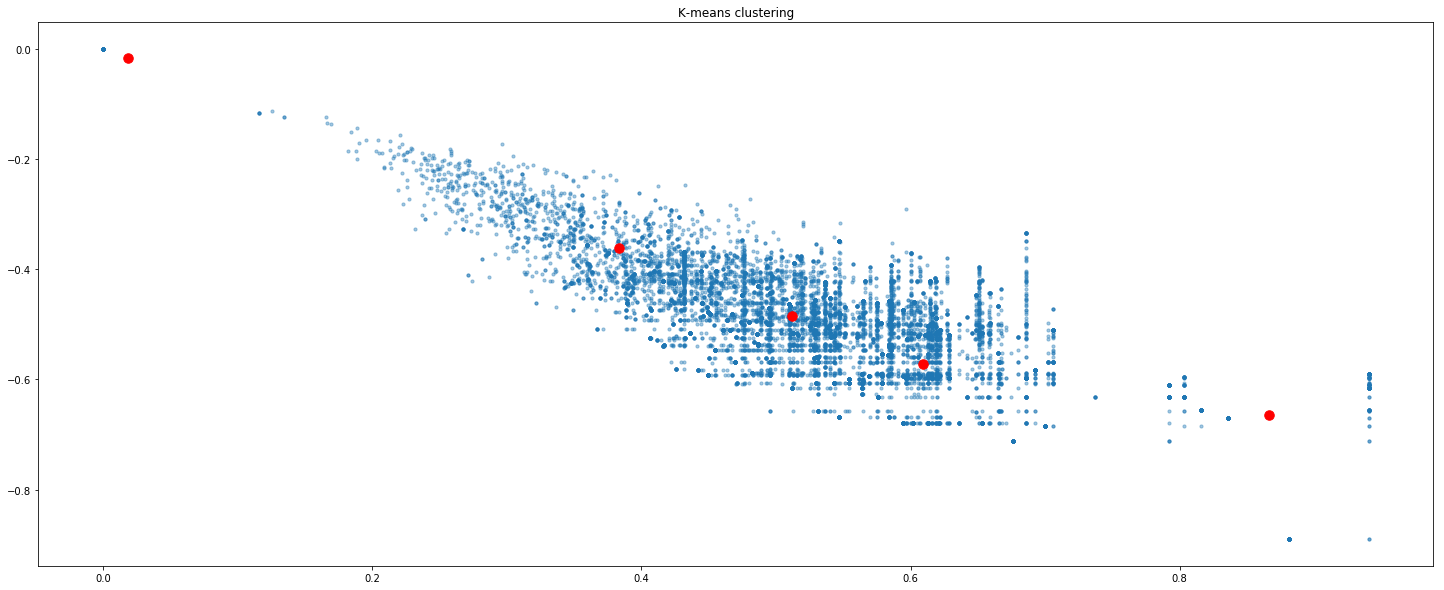

In [32]:
kmean_w2v = kmeans(sentence_vectors, 5)

In [33]:
clusters = {i: df['bio'][np.where(kmean_w2v.labels_ == i)[0]] for i in range(kmean_w2v.n_clusters)}

In [37]:
clusters[3]

3        PyData brings together users developers data a...
4        PyData brings together users developers data a...
5                        Contact pydatadelhi gmail dot com
6        Machine Learning Undergraduate Researcher usp ...
7        Director AI Tesla Previously Research Scientis...
12       Creative singer songwriter producer Merch Mana...
13       Creator Flask Building stuff getsentry prev fi...
22       Jack successful tech entrepreneur passionate A...
23       host dataleaders io founder TryResonateAI fun ...
26       Tweet Random things Reader Listener Junkie Gam...
27       Innovator Strategist Blogger Baller I create p...
29                            Product Developer statusbrew
30                                    Tech Freak Dog Lover
33                                          CEO statusbrew
43       Complete social media management platform disc...
47       Business Eco Fin Politics Views personal RTs e...
52                                   Co Founder CTO Open

### Word2Vec + TfIDF

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [39]:
vectorizer = TfidfVectorizer(max_df=0.5, max_features=300,
                                 min_df=2, stop_words='english',
                                 use_idf=True)

TfX = vectorizer.fit_transform(df['bio'])

In [40]:
feature_names = vectorizer.get_feature_names()
def get_tfidf_weight(doc):
    feature_index =TfX[doc,:].nonzero()[1]
    tfidf_scores = zip(feature_index, [TfX[doc, x] for x in feature_index])
    result = {}
    for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
        result[w] = s
    return result

In [41]:
get_tfidf_weight(10)

{'follow': 0.6167500033767237, 'youtube': 0.78715909023196273}

In [70]:
def embed_sentences_tfidf_weight(s, doc):
    sample_text_tokens = preprocess_text(s)
    word_vectors = np.array([]).reshape(0, 300)
    word_weights = get_tfidf_weight(doc)
    vector_weight = 1
    for t in sample_text_tokens:
        if t in word_weights:
            vector_weight = word_weights[t]
        if t in bio_vec.wv.vocab.keys():
            word_vectors = np.vstack([word_vectors, np.add(vector_weight, bio_vec[t])])
    if len(word_vectors):
        return np.array((np.max(word_vectors), np.min(word_vectors)))
    else:
        return [0, 0]

In [71]:
sentence_vectors_tf = np.array([]).reshape(0, 2)

i = 0
for index, row in df.iterrows():
    sentence_vectors_tf = np.vstack([sentence_vectors_tf, embed_sentences_tfidf_weight(row['bio'], i)])
    i+=1

Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=12, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=False)
done in 0.110s


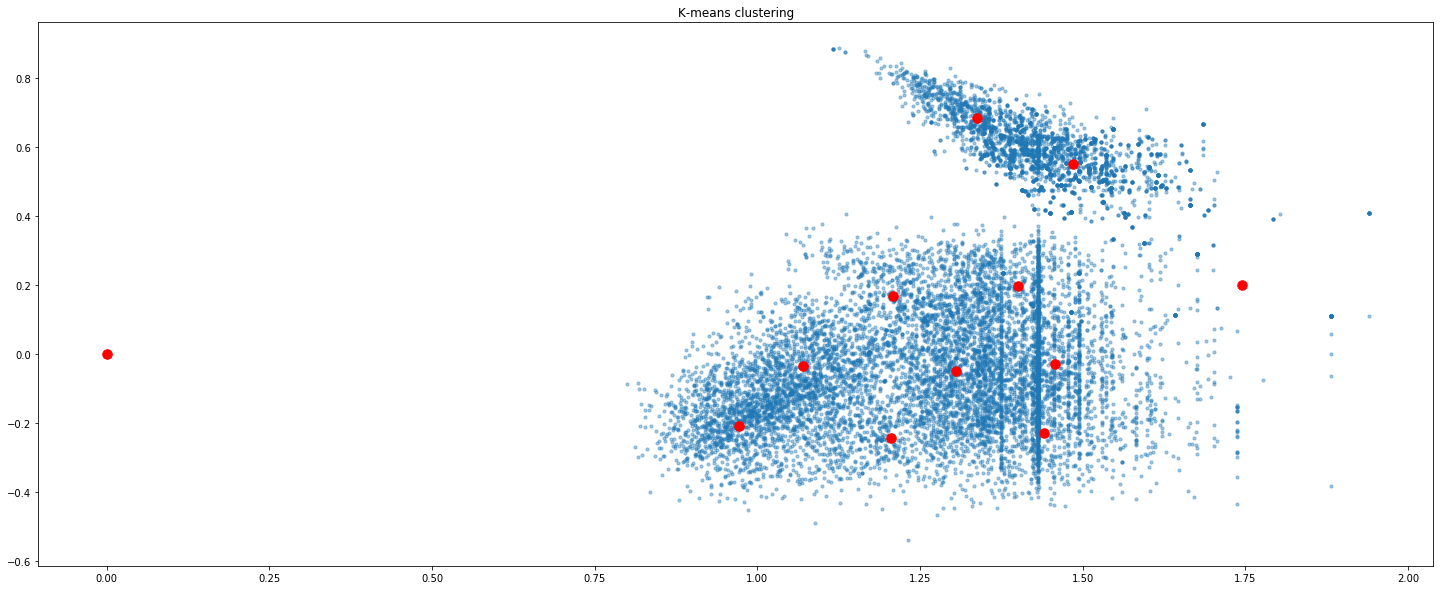

In [82]:
kmean_tfidf_w2v = kmeans(sentence_vectors_tf, 12)

In [83]:
clusters_tfidf = {i: df['bio'][np.where(kmean_tfidf_w2v.labels_ == i)[0]] for i in range(kmean_tfidf_w2v.n_clusters)}

In [85]:
clusters_tfidf[10]

1                                                  Patrick
32                         JPN IND statusbrew statusbrewjp
51                HYPERDUB UIQ PAN Dealing Mnestic Systems
72              Percent fresh water Earth icecaps glaciers
112                                                  Terms
113                                         astrophysicist
115          gallery HTML snippets playground getBootstrap
133                                  Fuck bystander effect
177                               Rockets day videos night
178      An element truth help change way people learn ...
179      NASA official source research science Internat...
182                          Tesla SpaceX OpenAI Neuralink
186                          SVP Samsung Wonderer Wanderer
201                            Office Prime Minister India
221      Golang Champion Web Perf Evangelist HTML CSS F...
230      Herbivore animalist Minister Church Flying Spa...
261      Research Fellow Computer Vision Robotics Cambr.

### Word2Vec + TfIDF + ResultantVec

In [109]:
def embed_sentences_tfidf_resultant(s, doc):
    text_tokens = preprocess_text(s)
    word_vectors = np.array([]).reshape(0, 300)
    word_weights = get_tfidf_weight(doc)
    vector_weight = 0
    v_words = 0
    for t in text_tokens:
        if t in word_weights:
            vector_weight = word_weights[t]
        if t in bio_vec.wv.vocab.keys():
            v_words+=1
            word_vectors = np.add(word_vectors, np.multiply(vector_weight, bio_vec[t]))
    if len(word_vectors):
        return np.array(np.mean(word_weights))
#         return word_vectors
    else:
        return [0, 0]

In [110]:
sentence_vectors_tf_resultant = np.array([]).reshape(0, 2)

i = 0
for index, row in df.iterrows():
    sentence_vectors_tf_resultant = np.vstack([sentence_vectors_tf_resultant, embed_sentences_tfidf_resultant(row['bio'], i)])
    i+=1

In [116]:
np.mean(bio_vec['hello'])

0.0072172377

Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=12, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=False)
done in 1.502s


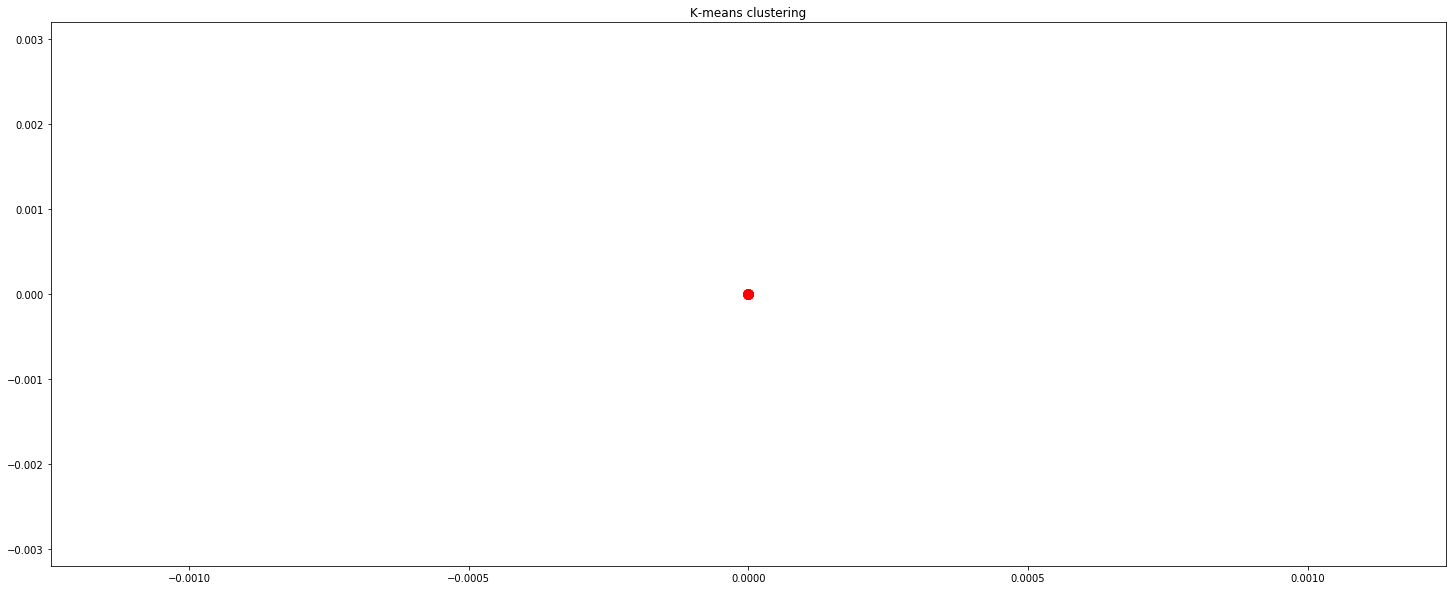

In [115]:
kmean_tfidf_result = kmeans(sentence_vectors_tf_resultant, 12)